# Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# Calibrate Camera

To calibrate camera we use chessboard images provided in the project folder.
```cv2.findChessboardCorners``` finds chessboard corners which are used to find distortion coeffecients and camera matrix.

In [4]:
# Let's import all calibration images and produce objectpoints and image points
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

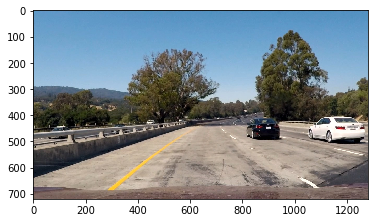

In [5]:
# Let's show one chessboard before calibration
#test_img = mpimg.imread('camera_cal/calibration1.jpg')
test_img = mpimg.imread('test_images/test1.jpg')
plt.imshow(test_img)

In [6]:
# Let's calibrate camera using objectpoints and imagepoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img.shape[1::-1], None, None)

# Undistort image

We use camera matrix and distortion coeffecients to undistort an image. This is the first step of our pipeline.

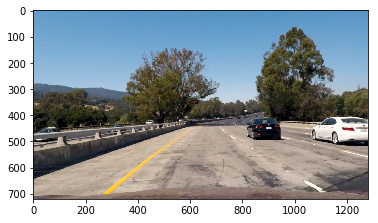

In [7]:
# Let's undistort the test image
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

undistorted_test_img = undistort(test_img)
plt.imshow(undistorted_test_img)

# Threshold an image

Next step of our pipeline is to convert undistorted RGB road image to binary image with lane lines being highlighted relative to its background.

To detect yellow line we use B channel of LAB color space. We select all pixels which are above 97th percentile of B channel values. Such a 97th percentile threshold is calculated in the lower half of the image to eliminate sky and increase influence of the road on percentile calculation.

To detect white line we use Y channel of YCrCb color space. The lower threshold is 97th percentile, upper threshold is max value of Y channel.

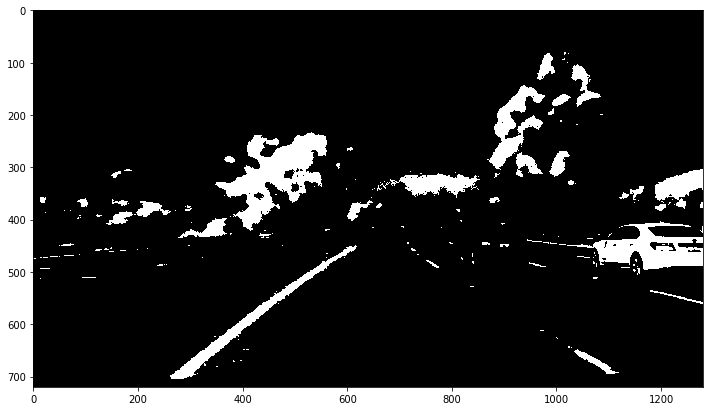

In [8]:
def threshold_image(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    margin = 70
    yellow_low = 15
    yellow_high = 35
    value_threshold = np.percentile(hls[:,:,1], 80)

    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    binary_mask = np.zeros_like(V)
    binary_mask[np.where(hls[:,:,1] > 255 - margin)] = 255
    binary_mask[np.where((hsv[:,:,0] >= yellow_low) & (hsv[:,:,0] <= yellow_high) & (hsv[:,:,2] >= value_threshold) & (hsv[:,:,1] >= 50))] = 255
    
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    ycb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]

    Y = ycb[:,:,0]
    Cr = ycb[:,:,1]
    Cb = ycb[:,:,2]

    height = Y.shape[0]
    B_threshold = np.percentile(B[(int)(height/2):height,:], 97)
    yellow_mask = np.zeros_like(B)
    yellow_mask[B>=B_threshold] = 1
    plt.figure(figsize=(12,12))
        
    Y_threshold = np.percentile(Y[(int)(height/2):height,:], 97)
    white_mask = np.zeros_like(Y)
    white_mask[Y>=Y_threshold] = 1
        
    return yellow_mask | white_mask
    

#test_img = mpimg.imread('debug/debug_14.jpg')
test_img = mpimg.imread('test_images/test1.jpg')
test_img = undistort(test_img)
thresholded = threshold_image(test_img)
plt.figure(figsize=(12,12))
plt.imshow(thresholded, cmap='gray')

# Perspective Transform

At this step we are finding direct and inverse perspective transform using source and destination points on some test image. Source points are four points on lane lines where two top points and two bottom points have same Y coordinate.
Destination points create rectangle.

Such transform allows to view road image from bird view which is convenient to estimate lane line polynomials.

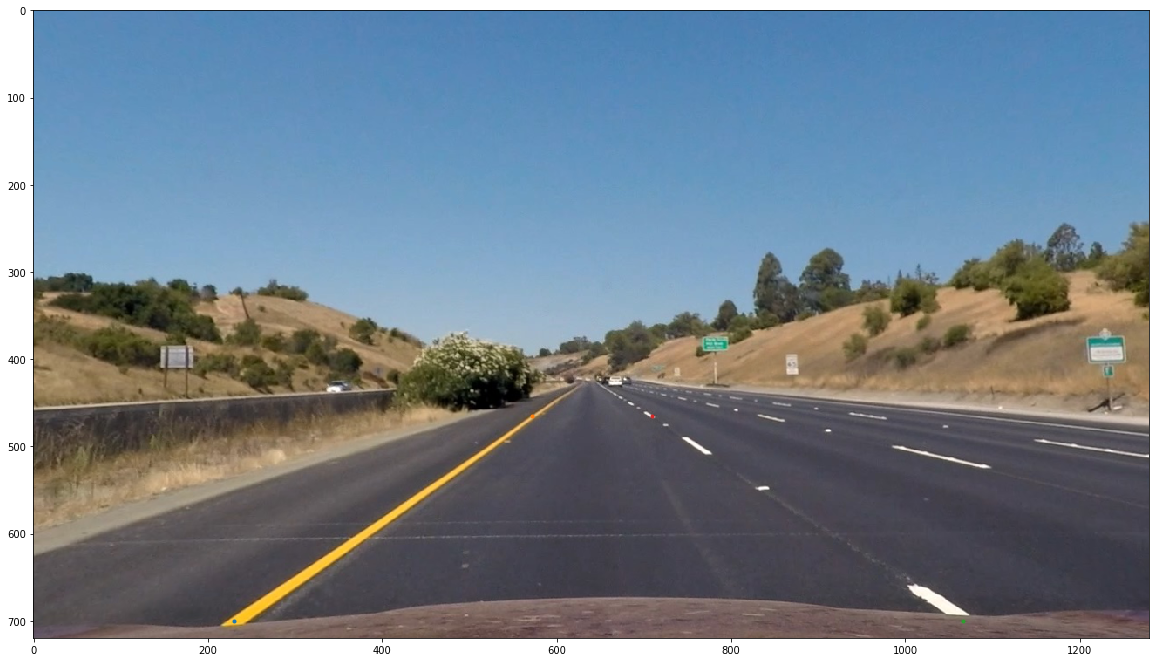

In [9]:
img = mpimg.imread('test_images/straight_lines1_undist.jpg')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.plot(230, 700, '.')
plt.plot(572, 465, '.')
plt.plot(1066, 700, '.')
plt.plot(709, 465, '.')

width = img.shape[1]
height = img.shape[0]
img_size = (width, height)

src = np.float32([[230, 700], [502, 514], [783, 514], [1066, 700]])
left_margin = 300
bottom_margin = 0
top_margin = 500
dst = np.float32([[left_margin, height-bottom_margin], [left_margin, top_margin], [width-left_margin, top_margin], [width-left_margin, height-bottom_margin]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


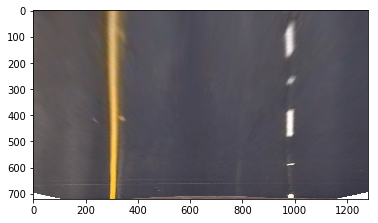

In [10]:
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

Here we perform three steps of our pipeline: undistort, threshold and warp on some test image.

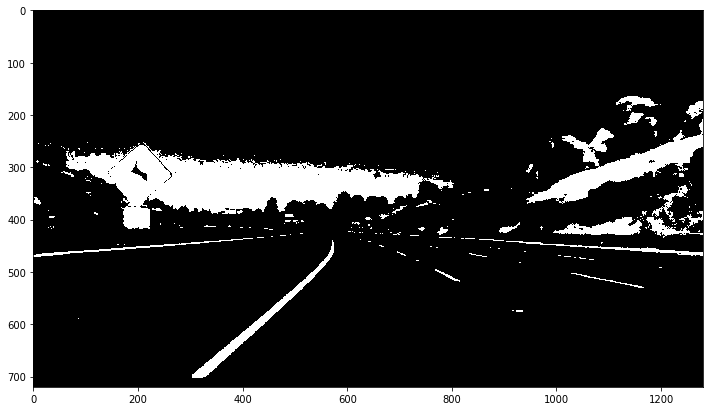

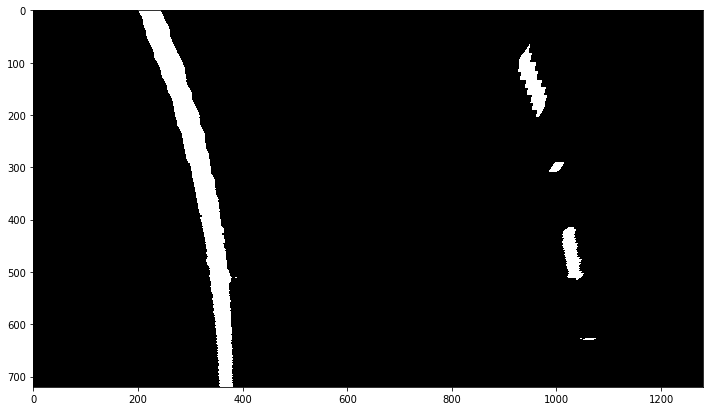

In [11]:
img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('debug/debug_14.jpg')
img = undistort(img)
img = threshold_image(img)
plt.figure(figsize=(12,12))
plt.imshow(img, cmap='gray')

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(12,12))
plt.imshow(warped, cmap='gray')

Preprocess function converts raw rgb road image to undistorted thresholded warped binary image. It will be used in the pipeline.

In [12]:
def preprocess(img):
    # Drop alpha channel if it is present
    img = img[:,:,:3]
    undist = undistort(img)
    binary = threshold_image(undist)
    warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    warped = np.uint8(warped*255)
    return warped, undist

# Extract lane pixels

In [13]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #y values for detected line pixels
        self.ally = None  

Here we define a function which takes warped binary image and outputs x, y coordinates of activated pixels which can be used to fit polynomials which estimate lane line.
Majority of below code was taken from the lecture exercise.

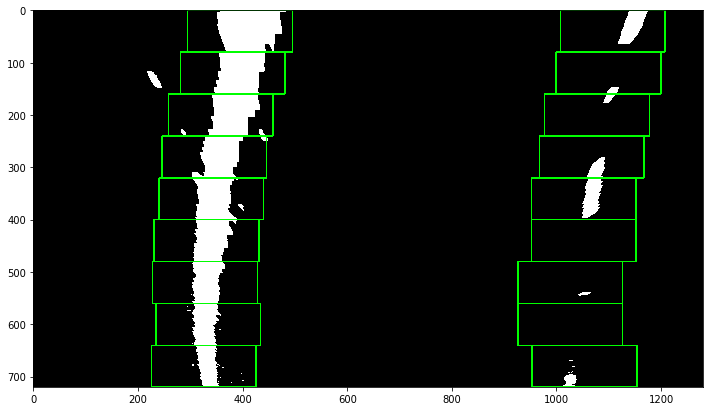

In [14]:
def getInitialCenters(img):
    height = img.shape[0]
    bottom_quarter = img[int(3*height/4):height,:]
    bottom_half = img[int(height/2):height,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)

def get_lane_pixels(img):
    leftx_current, rightx_current = getInitialCenters(img)
    
    out_img = np.dstack((img, img, img))
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_xs = []
    left_lane_ys = []
    right_lane_xs = []
    right_lane_ys = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        win_image_left = img[win_y_low:win_y_high,win_xleft_low:win_xleft_high]
        win_image_right = img[win_y_low:win_y_high,win_xright_low:win_xright_high]
        good_left_inds = win_image_left.nonzero()
        good_right_inds = win_image_right.nonzero()
        
        # Append these indices to the lists
        left_lane_ys.append(good_left_inds[0]+win_y_low)
        left_lane_xs.append(good_left_inds[1]+win_xleft_low)
        right_lane_ys.append(good_right_inds[0]+win_y_low)
        right_lane_xs.append(good_right_inds[1]+win_xright_low)
        
        if good_left_inds[1].shape[0] > minpix:
            leftx_current = int(np.mean(good_left_inds[1]))+win_xleft_low
            
        if good_right_inds[1].shape[0] > minpix:
            rightx_current = int(np.mean(good_right_inds[1]))+win_xright_low

    #Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_ys = np.concatenate(left_lane_ys)
    left_lane_xs = np.concatenate(left_lane_xs)
    right_lane_ys = np.concatenate(right_lane_ys)
    right_lane_xs = np.concatenate(right_lane_xs)

    return left_lane_xs, left_lane_ys, right_lane_xs, right_lane_ys, out_img
    
#img = mpimg.imread('debug/challenge_debug_18.jpg')
img = mpimg.imread('test_images/test1.jpg')
warped, undist = preprocess(img)
left_lane_xs, left_lane_ys, right_lane_xs, right_lane_ys, out_img = get_lane_pixels(warped)
plt.figure(figsize=(12, 12))
plt.imshow(out_img)

# Calculate polynomial

Here we define functions which fit 2-nd order polynomials for left and right lanes.

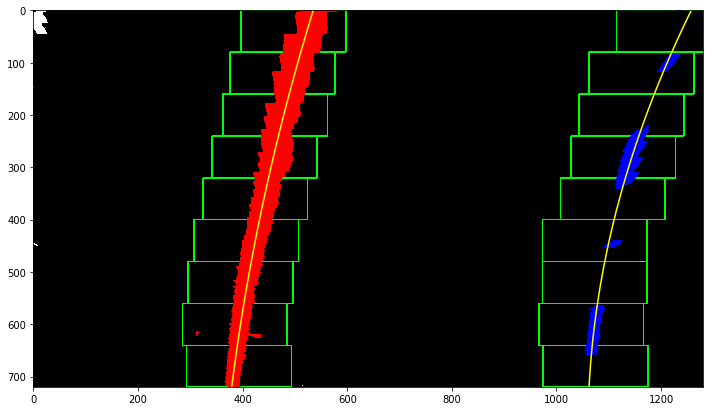

In [15]:
def fit_polynomial(leftx, lefty, rightx, righty, height):
    if leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0:
        return None, None, None, False
    
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, height-1, height )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fit, right_fit, True

def apply_polynomial(left_fit, right_fit, ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx
    
#img = mpimg.imread('test_images/test1.jpg')
img = mpimg.imread('debug/debug_100.jpg')
warped, undist = preprocess(img)
leftx, lefty, rightx, righty, out_img = get_lane_pixels(warped)
ploty, left_fit, right_fit, ret = fit_polynomial(leftx, lefty, rightx, righty, out_img.shape[0])
## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
left_fitx, right_fitx = apply_polynomial(left_fit, right_fit, ploty)
# Plots the left and right polynomials on the lane lines
plt.figure(figsize = (12, 12))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img, cmap='gray')
#plt.savefig('writeup_images/image10.jpg', bbox_inches='tight')

```search_around_poly``` is used to fit new polynomial using polynomial of left and right lane from previous video frame. This piece of code was taken from lecture exercise.

In [16]:
def search_around_poly(warped, left_fit, right_fit):
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = [index for index in range(len(nonzeroy)) if (left_fit[0]*(nonzeroy[index]**2)+left_fit[1]*nonzeroy[index]+left_fit[2]) >= nonzerox[index]-margin and (left_fit[0]*nonzeroy[index]**2+left_fit[1]*nonzeroy[index]+left_fit[2]) <= nonzerox[index]+margin ]
    right_lane_inds = [index for index in range(len(nonzeroy)) if (right_fit[0]*nonzeroy[index]**2+right_fit[1]*nonzeroy[index]+right_fit[2]) >= nonzerox[index]-margin and (right_fit[0]*nonzeroy[index]**2+right_fit[1]*nonzeroy[index]+right_fit[2]) <= nonzerox[index]+margin]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0:
        return None, None, None, False

    # Fit new polynomials
    height = warped.shape[0]
    ploty, left_fitx, right_fitx, ret = fit_polynomial(leftx, lefty, rightx, righty, height)
    
    return ploty, left_fitx, right_fitx, ret

# Pipeline helpers

```draw_lanes``` function draws lane lines using fitted polynomial coefficients and unwarps drawn image back to original coordinate system and overlays it over original road image creating an effect of green area drawn ahead of the car between two lane lines. This code has been taken from the lecture.

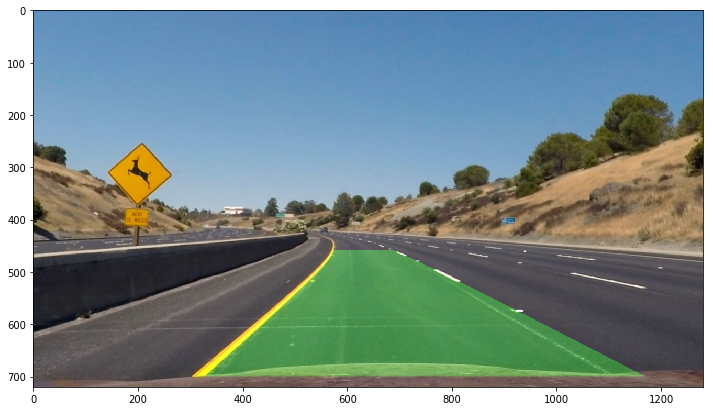

In [17]:
def draw_lanes(warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return np.array(result)
    
img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('debug/debug_100.jpg')
warped, undist = preprocess(img)
leftx, lefty, rightx, righty, out_img = get_lane_pixels(warped)
ploty, left_fit, right_fit, ret = fit_polynomial(leftx, lefty, rightx, righty, out_img.shape[0])
## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
left_fitx, right_fitx = apply_polynomial(left_fit, right_fit, ploty)
lanes_img = draw_lanes(warped, undist, left_fitx, right_fitx, ploty)
plt.figure(figsize=(12, 12))
plt.imshow(lanes_img)

This function applies polynomial coefficients to some given point y to obtain x=f(y).

In [16]:
def f(fit, y):
    x = fit[0]*(y**2)+fit[1]*y+fit[2]
    return x

This function calculates curvature of the lane line in meters using polynomial coefficients.

In [17]:
def calculate_meters_curvature(left_fit, right_fit, height):
    my = 30/720 # meters per pixel in y dimension
    mx = 3.7/880 # meters per pixel in x dimension

    y_eval = height
    y_eval_m = y_eval*my
    left_curverad = (1+(2*(mx/(my**2))*left_fit[0]*y_eval_m+(mx/my)*left_fit[1])**2)**1.5/np.absolute(2*(mx/(my**2))*left_fit[0])
    right_curverad = (1+(2*(mx/(my**2))*right_fit[0]*y_eval_m+(mx/my)*right_fit[1])**2)**1.5/np.absolute(2*(mx/(my**2))*right_fit[0])
    return left_curverad, right_curverad

This function calculates offset of the car center from the lane center in meters. It uses warped binary image and polynomial coefficients of the left and right lane to perform such calculation.

In [18]:
def calculate_offset(warped_img, left_fit, right_fit):
    height = warped_img.shape[0]
    width = warped_img.shape[1]
    
    y_eval = height-1
    
    x_l = f(left_fit, y_eval)
    x_r = f(right_fit, y_eval)
    
    line_width = x_r-x_l
    
    center = int((x_l+x_r)/2)
    image_center = int(width/2)
    
    xm_per_pix = 3.7/line_width # meters per pixel in x dimension
    
    offset = (center - image_center)*xm_per_pix
    
    # if offset is positive, vehicle is on the left
    return offset

This function writes text on image. It is used for visualization of lane curvature and car center offset.

In [19]:
def write_text_on_image(img, text, level = 1):
    width = img.shape[1]
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (30,70)
    if level == 2:
        bottomLeftCornerOfText = (30, 120)
    fontScale              = 1.5
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(img, text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

Simpe sanity check of left and right line relative curvature. We discard estimated polynomials if curvature differs more than 5 times.

In [20]:
def sanity_check(left_fit, right_fit, height):
    left_curvature, right_curvature = calculate_meters_curvature(left_fit, right_fit, height)
    
    # Polynomials with low curvature are probably incorrectly estimated
    if left_curvature <= 100 or right_curvature <= 100:
        return False
    
    ratio = left_curvature/right_curvature
    accepted_ratio = 3.0
    if ratio >accepted_ratio or ratio < 1/accepted_ratio:
        return False
    
    return True

Weights used for weighted average of left and right lane polynomials.

In [21]:
weights = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

One of tha main functions of the pipeline, it gets warped and undistorted images and left and right line data from previous video frames.
It calculates new left and right polynomials using polynomials from previous frames, runs sanity check on new polynomial and if sanity check is passed adds new polynomial coefficients to historical data of 10 last polynomials.
After that it finds weighted average polynomial giving higher weight to recent estimations.

Such averaged polynomial coefficients are used to draw line lanes on undistorted image of the road.
Also such averaged polynomial coefficients are used to estimate lane curvatures and car center offset from the middle of the lane. Curvature and offset are drawn at the top of the image as text.

In [22]:
# This function gets new warped image, obtains polynomial fit data for this image and updates left and right lines
def update_lines(warped_img, undist_img, left_line, right_line):
    n = 10
    height = warped_img.shape[0]
    
    if left_line.best_fit == None or right_line.best_fit == None:
        leftx, lefty, rightx, righty, out_img = get_lane_pixels(warped_img)
        ploty, left_fit, right_fit, ret = fit_polynomial(leftx, lefty, rightx, righty, out_img.shape[0])
    else:
        ploty, left_fit, right_fit, ret = search_around_poly(warped_img, left_line.best_fit, right_line.best_fit)
    
    if ret == True and sanity_check(left_fit, right_fit, height) == False:
        ret = False

    if ret == False:
        left_fit = None
        right_fit = None
        
    if len(left_line.current_fit) >= n:
        left_line.current_fit.pop(0)
        
    if len(right_line.current_fit) >= n:
        right_line.current_fit.pop(0)
        
    left_line.current_fit.append(left_fit)
    right_line.current_fit.append(right_fit)
    
    if left_line.ally == None and ploty is not None:
        left_line.ally = ploty
        right_line.ally = ploty
    
    left_fit_to_average = [x for x in left_line.current_fit if x is not None]
    right_fit_to_average = [x for x in right_line.current_fit if x is not None]
    
    if len(left_fit_to_average) > 0 and len(right_fit_to_average) > 0:
        count = len(left_fit_to_average)
        average_left_fit = np.average(left_fit_to_average, axis=0, weights=weights[n-count:n:])
        average_right_fit = np.average(right_fit_to_average, axis=0, weights=weights[n-count:n:])

        left_fitx, right_fitx = apply_polynomial(average_left_fit, average_right_fit, left_line.ally)
    
        lanes_img = draw_lanes(warped_img, undist_img, left_fitx, right_fitx, left_line.ally)
        
        left_curvature, right_curvature = calculate_meters_curvature(average_left_fit, average_right_fit, height)
        left_line.radius_of_curvature = left_curvature
        right_line.radius_of_curvature = right_curvature
        write_text_on_image(lanes_img, "Left curvature: {left_curvature:.0f} m, Right curvature: {right_curvature:.0f} m.".format(left_curvature=left_curvature, right_curvature=right_curvature))
            
        offset = calculate_offset(warped_img, average_left_fit, average_right_fit)
        write_text_on_image(lanes_img, "Vehicle is {offset:.2f}m {direction} of center.".format(offset=np.absolute(offset), direction='left' if offset > 0 else 'right'), 2)
            
        left_line.best_fit = average_left_fit
        right_line.best_fit = average_right_fit
        left_line.detected = True
        right_line.detected = True
        return lanes_img, left_line, right_line, True
    
    left_line.detected = False
    right_line.detected = False
    left_line.radius_of_curvature = None
    right_line.radius_of_curvature = None
    left_line.best_fit = None
    right_line.best_fit = None

    return undist_img, left_line, right_line, False
    

The function which is actually invoked for each video frame it simply preprocessed an image getting warped and undistorted image and calls ```update_lines``` to draw lane lines and curvature with car center offset on the image.

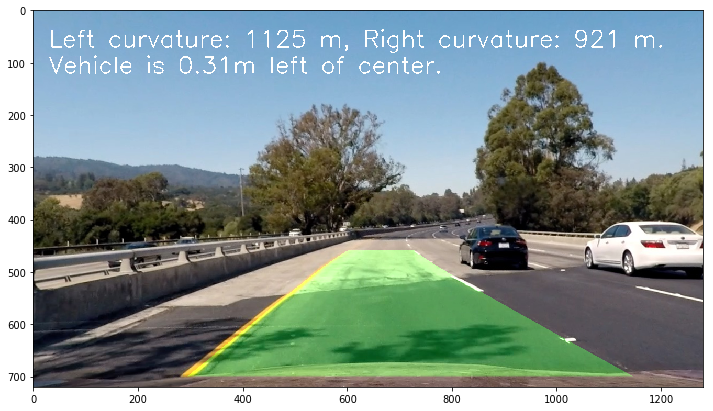

In [25]:
def process_image(img):
    #global img_debug_counter
    global left_line
    global right_line
    #mpimg.imsave('debug/debug_' + str(img_debug_counter)+".jpg", img)
    #img_debug_counter+=1
    warped, undist = preprocess(img)
    lanes_img, left_line, right_line, ret = update_lines(warped, undist, left_line, right_line)
        
    return lanes_img

left_line = Line()
right_line = Line()
img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('debug/debug_10.jpg')
processed = process_image(img)
plt.figure(figsize=(12, 12))
plt.imshow(processed)
#mpimg.imsave('writeup_images/image9.jpg', processed, cmap='gray')

Running the pipeline on project video, first crearing states for left and right line.

In [27]:
# Import everything needed to edit/save/watch video clips
import sys
!conda install --yes --prefix {sys.prefix} requests
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [ ]:
video_output = 'test_video_output/project_video.mp4'
left_line = Line()
right_line = Line()
img_debug_counter = 0
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(process_image)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/project_video.mp4
[MoviePy] Writing video test_video_output/project_video.mp4


100%|█████████▉| 1260/1261 [07:23<00:00,  2.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/project_video.mp4 

CPU times: user 9min 56s, sys: 9.83 s, total: 10min 6s
Wall time: 7min 24s


In [ ]:
video_output = 'test_video_output/challenge_video.mp4'
img_debug_counter = 0
left_line = Line()
right_line = Line()
clip2 = VideoFileClip("challenge_video.mp4")#.subclip(4,6)
processed_clip2 = clip2.fl_image(process_image)
%time processed_clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/challenge_video.mp4
[MoviePy] Writing video test_video_output/challenge_video.mp4


100%|██████████| 485/485 [01:56<00:00,  3.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_video.mp4 

CPU times: user 2min 55s, sys: 2.82 s, total: 2min 58s
Wall time: 1min 57s


In [ ]:
video_output = 'test_video_output/harder_challenge_video.mp4'
clip2 = VideoFileClip("harder_challenge_video.mp4")
processed_clip2 = clip2.fl_image(process_image)
%time processed_clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/harder_challenge_video.mp4
[MoviePy] Writing video test_video_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [08:22<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/harder_challenge_video.mp4 

CPU times: user 10min 24s, sys: 7.72 s, total: 10min 31s
Wall time: 8min 24s
